# <u> Zillow Clustering Project</u>

### __Title:__ Factors Driving errors in the Z-estimes

### __Data Source:__ Zillow, 2017 Single Household Homes for Orange, Ventura and Los Angeles Counties

##### by,
>  Stephen Kipkurui | Zillow Team Data Scientist  | April, 20122
<hr>



# Project Overview


### This project report is a continuation of the Regression Project, March, 2022.  The goal with this project however is to explore new features (as well as the old features discussed in the last project) in understanding drivers for Zillow's e-estimate (log error). The approach includes implementation of clustering techniques in exploration of data. 





> #### Import Libraries

In [162]:
# Import Main Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import User Defined Modules
import wrangle
import acquire
import evaluate
from wrangle import drop_and_rename

# Import Sklearn Modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans

# Import Stats Module
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr

from datetime import datetime, date

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

<hr>

# Project Approach:

> ### Data Science Pipeline

<hr>


# <u>Planning</u>

- #### The stakeholder --> Zillow Data Sceince Team
- #### Business objective --> Implement model for predicting drivers for error in the z-estimate (build on progression model)
- #### Data source --> CodeUp\'s online SQL Database 2017 Zillow. (Date of acquisition: April, 2022).


### Additional Setups 
- ##### GitHub Repository (<u>git@github.com:stephenkipkurui/regression-project.git</u>). 
- ##### Mitigate data leakage. (No leakage into test set exprienced in this project)
- ##### Documented process and delivery report


# <u>Data Acquisition</u>

> ## Get main Original DataFrame

In [2]:
# Acquire zillow dataframe

df = acquire.acquire_zillow()

Status: Acquiring data from csv file..


In [3]:
# Examine dataframe shape

df.shape

(52451, 68)

- ### Original DataFrame contains 52_451 rows & 68 columns 
- ### Guard against data leakage before spitting

# <u>Prepare</u>

### Wrangle.py module...
- ##### Dropped any duplicates & null data rows
- ##### Renamed columns {
                   'bedroomcnt':'bed_count','bathroomcnt':'bath_count',
                   'calculatedfinishedsquarefeet':'square_feet',
                   'taxvaluedollarcnt':'assessed_value', 'fips':'fips',
                   'yearbuilt':'year_built','transactiondate':'trans_date'
                   }
                   
- ##### Renamed Columns:
    - Generalized format--> add space-bar between words for readability
    - Reduced long words to shortened words (See README.md Data Dictionary)
                   
- ##### Outliers:
    - Removed outliers as follows:
        - Stripped bathrooms  >  7.5
        - Stripped bedrooms over 8
        - Stripped Square feet over 12000 feet
        - Stripped full bathrooms counts over 6
        - Binned unit counts and stripped those over 1.25
        - Retained homes build after 1910
        - Binned tax value counts and stripped those over 2
        - Stripped tax amount over 300,000
            
- ##### Missing Values: 
    - Removed columns with over 60% missing values 
    - Removed rows with over 75% missing values
    - Calculated mean average of columns and filled remaining nulls with mean 
    
- ##### Split Data 

    - Train: 33568 rows, 68 cols
    - Validate: 8392 rows, 68 cols
    - Test: 10491 rows, 68 cols
  
- ##### Scaled Data (modeling data)
    - Scaled these columns in preparation for modeling:
        - Bathroom count
        - Bedroom counts
        - Age of home
        - Property lot/ land size
        - Home's square feet
        - Tax amount

- ##### Engineered Columns: 
    - Binnned columns:
        - Square feet
        - Lot size
        - Age of home (calculates age till 2017)
        - Acres of land
        - Bath ratio (bathroom / bedrooms)
        
    - New column:
        - City
        
    - Clustered columns:
        - Square feet & tax value cluster
        - Bedrooms, age & lot size cluster 
    
- ##### Fips refference U.S. Federal resources (https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)                   
                   


> ### Dropped, renames, added features

In [7]:
df = drop_and_rename()

Status: Acquiring data from csv file..


> ### Split the data into train, validate & test

In [13]:
# Check the shape integrity

train, validate, test = wrangle.split_data(df)

Train: 33568 rows, 60 cols
Validate: 8392 rows, 60 cols
Test: 10491 rows, 60 cols


> ### Fill nulls with overall mean

In [15]:
train = train.fillna(train.mean())
validate = validate.fillna(validate.mean())
test = test.fillna(test.mean())

In [17]:
train.head(2)

,basement_sqft,bath_cnt,bed_cnt,calc_square_feet,fips,fire_place_cnt,full_bath_cnt,garage_car_cnt,garage_total_sqft,has_hot_tub_or_spa,...,acres,acres_bin,sqft_bin,bedrooms_bin,structure_amount_per_sqft,structure_amount_sqft_bin,land_amount_per_sqft,lot_amount_sqft_bin,bath_bed_ratio,cola
30541,622.3125,1.0,3.0,1530.0,6037.0,1.202889,1.0,1.950871,495.580972,1.0,...,0.255303,0.3,0.4,0.3,27.658824,0.1,0.202320,0.0,0.333333,0
23571,622.3125,2.0,3.0,1447.0,6059.0,1.202889,2.0,2.000000,411.000000,1.0,...,0.139509,0.1,0.3,0.3,78.345543,0.3,37.959355,0.3,0.666667,0


> ### Percentage of Columns Dropped after Preparation

- ###### Dropped 36% nulls rows (18,939 rows) from original 52,451. 
- ###### Dropped 8% columns (8) from 68. 

# <u>Exploratory Data Analysis</u>

- Q1. Does the size of __land (lot size)__ affect the errors in z-estimate?
- Q2. Does the __home square feet__ of homes affect z-estimate?
- Q3. Controlling __location (counties)__, how is the z-estimate affected?
- Q4. Controlling __tax value__, how is the z-estimate affected?
- Q5. Lastly how are the __age of the homes__ in counties affect z-estimates counties?
- Q6. How are the means average sizes of land and home square feet in different counties affect z-estimate.
#### What features are driving the log_error?
 > - Perform feature engineering with SelectKBest to identify drivers
 > - Do combined features have enhanced effect of log_error?

#### Confidence level (Alpha level) = 0.05 

> ### Visualize Raw Data

Interaction of variables along with younger vs older
(cutoff=40)


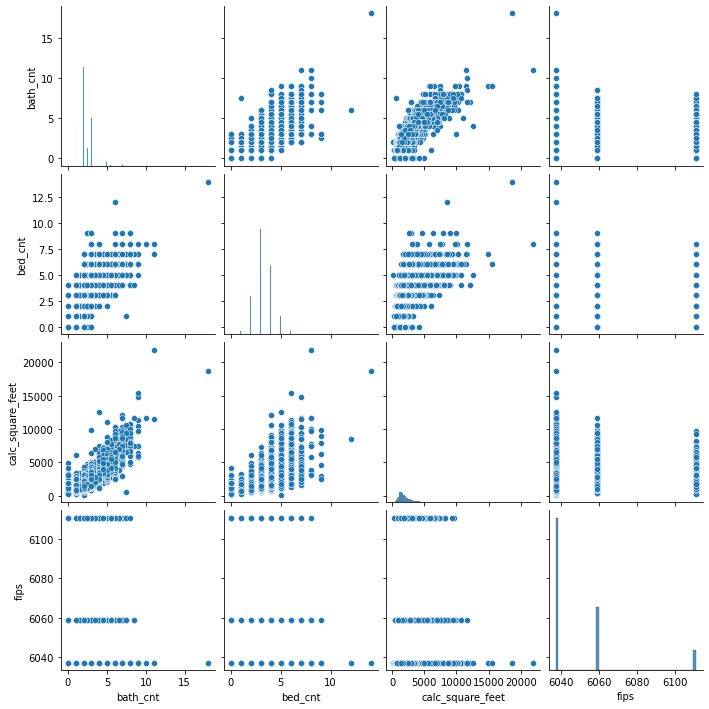

In [60]:
print("Interaction of variables along with younger vs older\n(cutoff=40)")
sns.pairplot(train[['bath_cnt', 'bed_cnt', 'calc_square_feet','fips']])
plt.show()


Interaction of variables along with younger vs older
(cutoff=40)


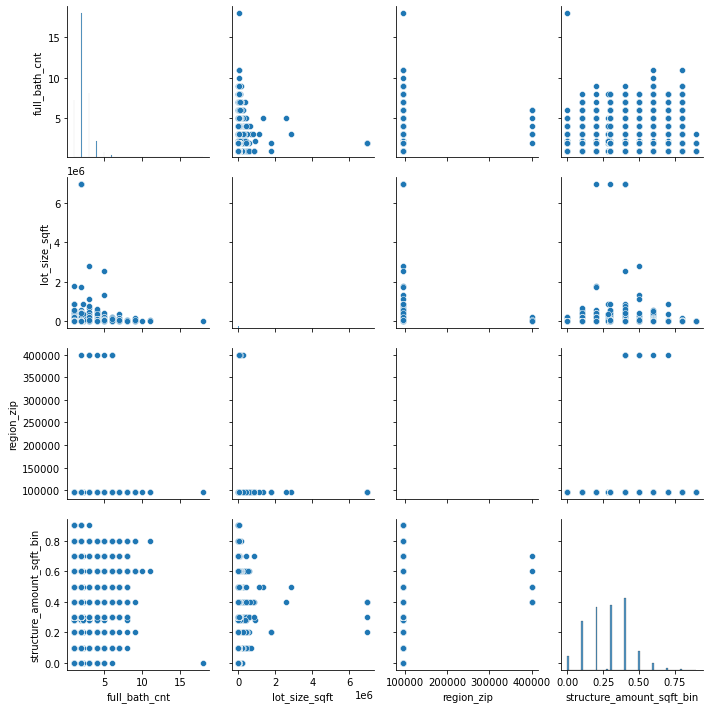

In [61]:
print("Interaction of variables along with younger vs older\n(cutoff=40)")
sns.pairplot(train[['full_bath_cnt','lot_size_sqft','region_zip', 'structure_amount_sqft_bin']])
plt.show()


> ### (i). Lot size VS log error

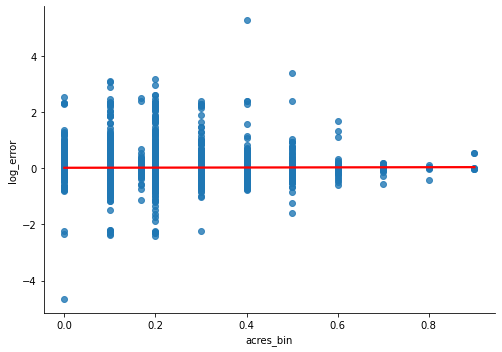

In [51]:
# Create lmplot showing regression

sns.lmplot(x="acres_bin", y="log_error", data = train, 
            height = 5, aspect = 11.7/8.27, line_kws={'color': 'red'})

> ### T-Test (PearsonR)

In [88]:
# Set alpha level
alpha = 0.05
# Hypothesis
H0 = 'There is no correlation between homes land size and z-estimate error'
H1 = 'Homes land size affects z-estimate error'
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p = pearsonr(train.lot_size_sqft, train.log_error)
print(f'\tCorrelation Coefficient (r value): {r}\n\tP-value: {p}')
if p < alpha:
    print(f"\n\tFAILED TO REJECT:- {H0}\n")
else:
    print(f"\n\tREJECT:- {H0}")
print('\n\t\tInterpretation---> lot affects z-score minimally')

	Correlation Coefficient (r value): 0.00884499171655652
	P-value: 0.10512215121949503

	REJECT:- There is no correlation between homes land size and z-estimate error

		Interpretation---> lot affects z-score minimally


> ### (ii). Home square feet VS log error

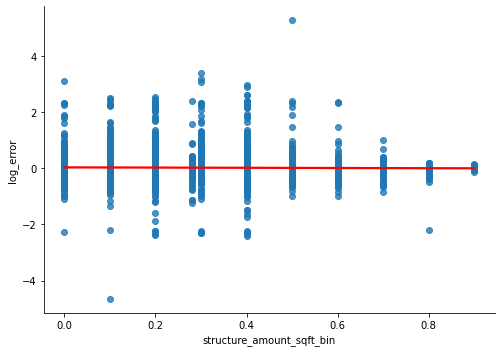

In [70]:
# Create lmplot showing regression
sns.lmplot(x="structure_amount_sqft_bin", y="log_error", data = train, 
            height = 5, aspect = 11.7/8.27, line_kws={'color': 'red'})

> ### T-Test (PearsonR)

In [86]:
H0 = 'There is no correlation between homes square feet and z-estimate error'
H1 = 'Homes square feet affects z-estimate error'
alpha = 0.05
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p = pearsonr(train.sqft_bin, train.log_error)
print(f'\n\tCorrelation Coefficient: {r}\n\tP-value: {p}\n')
if p < alpha:
    print(f"\n\tFAILED TO REJECT:- {H0}")
else:
    print(f"\n\tREJECT:- {H0}")
print('\n\t\tInterpretation---> home square feet does not affect z-score')


	Correlation Coefficient: 0.032369049220222074
	P-value: 2.995364417541659e-09


	FAILED TO REJECT:- There is no correlation between homes square feet and z-estimate error

		Interpretation---> home square feet does not affect z-score


> ### (iv). Location VS log error

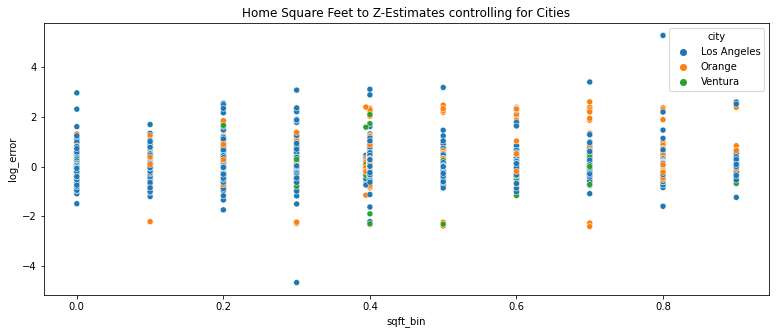

In [100]:
plt.figure(figsize = (13, 5))
sns.scatterplot(x='sqft_bin', y='log_error', data=train, hue='city')
plt.title('Home Square Feet to Z-Estimates controlling for Cities')
plt.show()

> ### T-Test(Levene)

In [94]:
H_0 = 'There is no correlation between different cities homes square feet and z-estimate error'
H_1 = 'Homes square feet in different cities affects z-estimate error same way'
stat, p = stats.levene(train[train.city == 'Los Angeles'].lot_size_sqft, 
             train[train.city == 'Orange'].lot_size_sqft, 
             train[train.city == 'Ventura'].lot_size_sqft)
stat, p

(7.946681776523836, 0.00035450044611771243)

In [95]:
if p / 2 < alpha:
    print(f"\n\tFAILED TO REJECT:- {H_0}\n")
else:
    print(f"\n\tREJECT:- {H_0}\n")


	FAILED TO REJECT:- There is no correlation between different cities homes square feet and z-estimate error



> ### (v). Tax VS log error

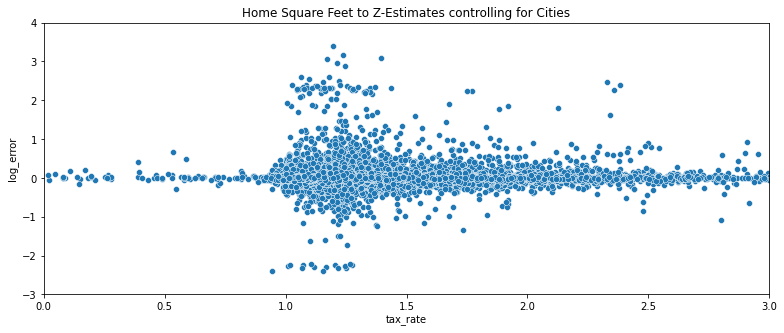

In [102]:
plt.figure(figsize = (13, 5))
sns.scatterplot(x='tax_rate', y='log_error', data = train)
plt.title('Home Square Feet to Z-Estimates controlling for Cities')
plt.xlim(0, 3)
plt.ylim(-3, 4)
plt.show()

> ### (vi). Home Age VS log error

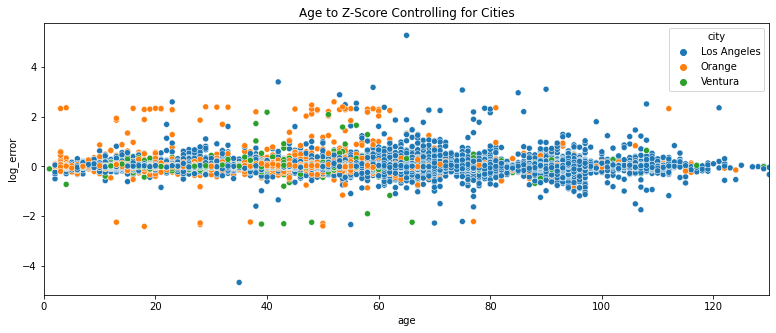

In [105]:
plt.figure(figsize = (13, 5))
sns.scatterplot(x='age', y='log_error', data=train, hue = 'city')
plt.title('Age to Z-Score Controlling for Cities')
plt.xlim(0, 130)
plt.show()

> ### Top Drivers for Z-estimate (SelectKBest)
    - Bathroom count
    - Bedroom count
    - Square feet
    - Zip code (fips)
    - Full bath counts
    - Latitude
    - Longitude
    - Lot size square feet
    - Census track & block
    - Property region 
    - Room counts
    - Unit counts
    - Year home built (age)
    - Tax value
    - Tax Amount

> ## Clustering
#### (I). With 2 features 
- Home Square feet
- Tax Amount)

In [138]:
# Create X onject and predict kmeans
X = train_scaled[['calc_square_feet',  'tax_amount']]
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)
kmeans.predict(X)
train_scaled['sqft_tax_cluster'] = kmeans.predict(X)

> ### Visualize the clusters 

> #### Squre Feet Key:
    - bins = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000, 12000],
    - labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]

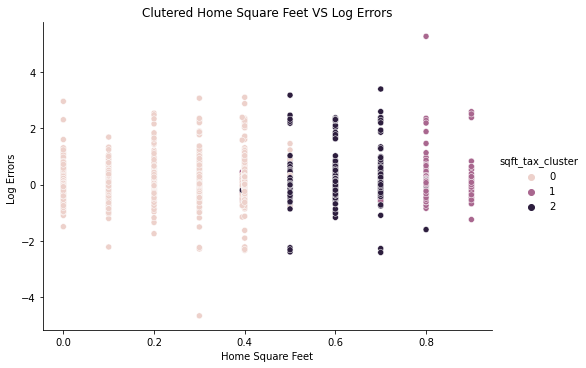

In [149]:
sns.relplot(data = train_scaled, x = 'sqft_bin', y = 'log_error',
            hue='sqft_tax_cluster', height = 5, aspect = 11.7 / 8.27)
plt.title('Clutered Home Square Feet VS Log Errors')
plt.xlabel('Home Square Feet')
plt.ylabel('Log Errors ')
# plt.xlim(-1000, 12000)
plt.show()

In [146]:
# Create centroids object
kmeans.cluster_centers_
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)
centroids

,calc_square_feet,tax_amount
0,0.057833,0.007192
1,0.235546,0.049261
2,0.119043,0.015132


### Group by Clusters

In [150]:
# Group by clusters
train_scaled.groupby('sqft_tax_cluster')['log_error','calc_square_feet',  'tax_amount'].mean()

,log_error,calc_square_feet,tax_amount
sqft_tax_cluster,,,
0,0.015092,0.057815,0.007191
1,0.055111,0.235305,0.049162
2,0.022348,0.118969,0.015118


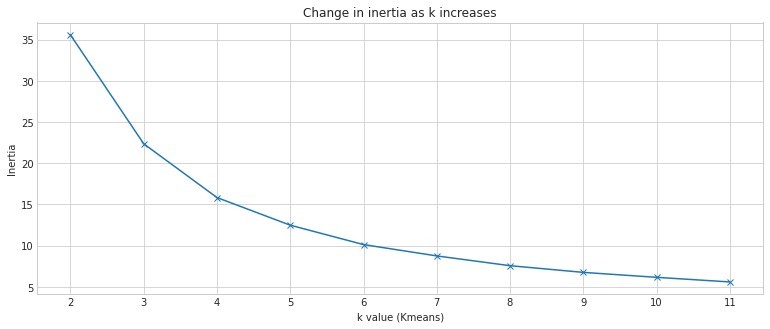

In [153]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13, 5))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}
              ).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k value (Kmeans)')
    plt.ylabel('Inertia')
    plt.title('Change in inertia as k increases')

### Summary (tax amount and square feet):-
- #### (2 features (tax amount and square feet), Optimal clusters == 4)

### (ii). 3 Features:- 
- Bed Count
- Age 
- Home Lot Size

Text(0.5, 0.98, "clusters based on ['bed_cnt', 'age', 'lot_size_sqft']")

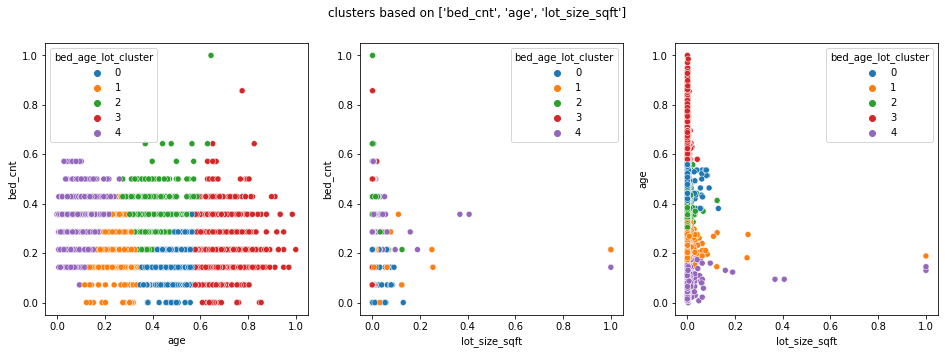

In [158]:
X2 = train_scaled[['bed_cnt','age', 'lot_size_sqft']]
kmeans = KMeans(n_clusters =5)
kmeans.fit(X2)
train_scaled['bed_age_lot_cluster'] = kmeans.labels_
train_scaled.bed_age_lot_cluster = train_scaled.bed_age_lot_cluster.astype('category')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

sns.scatterplot(data=train_scaled, y='bed_cnt', x='age', hue='bed_age_lot_cluster', ax=ax1)
sns.scatterplot(data=train_scaled, y='bed_cnt', x='lot_size_sqft', hue='bed_age_lot_cluster', ax=ax2)
sns.scatterplot(data=train_scaled, y='age', x='lot_size_sqft', hue='bed_age_lot_cluster', ax=ax3)
fig.suptitle(f'clusters based on {X2.columns.tolist()}')

In [160]:
# Group by clusters
train_scaled.groupby('bed_age_lot_cluster')['log_error','bed_cnt','age', 'lot_size_sqft'].mean()

,log_error,bed_cnt,age,lot_size_sqft
bed_age_lot_cluster,,,,
0,0.013657,0.191461,0.475464,0.001288
1,0.016729,0.233174,0.254891,0.001910
2,0.026589,0.276344,0.393945,0.001383
3,0.009064,0.198133,0.673098,0.001038
4,0.024567,0.290024,0.110406,0.002904


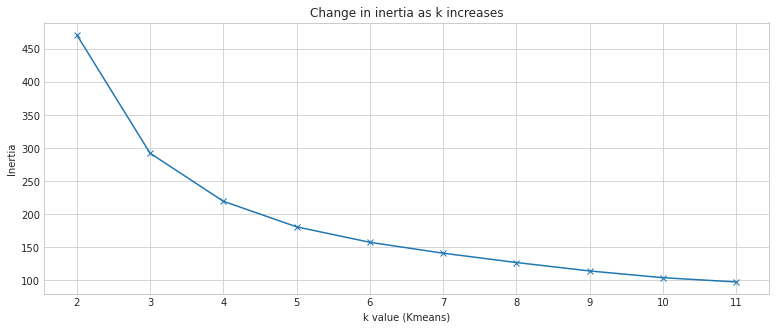

In [161]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13, 5))
    pd.Series({k: KMeans(k).fit(X2).inertia_ for k in range(2, 12)}
              ).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k value (Kmeans)')
    plt.ylabel('Inertia')
    plt.title('Change in inertia as k increases')

## Exploration TakeAways:
>### Log Error Greatest In:
- __Bed count 2-4__ followed by 5 and 1
- __Bathroom counts 1, 2, 3, 4__
- __Tax rate (binned) between 1.0- 1.5__ and skews right to 3.0 (tax rate = tax amount / tax count)
- __Los Angeles has higher tax rate__ followed by Orange and least Ventura
- Homes with __square feet around 1500 have high log errors__, skews right to about 6000 square feet.
- Majority of __1500 square feet homes with high log-errors are in Los Angeles__, followed by Orange County. 
> ### Even distribution of Log Errors:
- __Age of home__ 
- __Latitude and Longitude__  


> ### Features Moving into Modeling:
- Bathroom (1 - 7.5)
- Bedroom count (0 - 8)
- Age of Home (Homes built after 1910)
- Lot Size
- Square feet (Single Family Homes < 12000)

# <u>Modeling</u>

> ### Acquire Scaled Data For Modeling (MinMaxScaler)

In [113]:
train_scaled, validate_scaled, test_scaled = wrangle.scale_data(train, validate, test)

> ### Create Baseline

In [118]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict log_error_pred_mean
log_error_pred_mean = y_train['log_error'].mean()
y_train['log_error_pred_mean'] = log_error_pred_mean
y_validate['log_error_pred_mean'] = log_error_pred_mean
# 2. RMSE of log_error_pred_mean
rmse_train_bl = mean_squared_error(y_train.log_error, y_train.log_error_pred_mean)**(1/2)
rmse_validate_bl = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_mean)**(1/2)

print("RMSE Baseline (Mean)\n\tTrain-In-Sample: ", round(rmse_train_bl, 2), 
      "\n\tValidate/Out-of-Sample: ", round(rmse_validate_bl, 2))

RMSE Baseline (Mean)
	Train-In-Sample:  0.18 
	Validate/Out-of-Sample:  0.19


### A). Linear Regression (Best Model)

In [122]:
# create the model object
lm = LinearRegression(normalize = True)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.log_error)
# predict train
y_train['log_error_pred_lm'] = lm.predict(X_train)
# evaluate: rmse
rmse_train_lr = mean_squared_error(y_train.log_error, y_train.log_error_pred_lm)**(1/2)
# predict validate
y_validate['log_error_pred_lm'] = lm.predict(X_validate)
# evaluate: rmse
rmse_validate_lr = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_lm)**(1/2)
print("RMSE for OLS using LinearRegression\n\tTraining/In-Sample: ", rmse_train_lr, 
      "\n\tValidation/Out-of-Sample: ", rmse_validate_lr)

RMSE for OLS using LinearRegression
	Training/In-Sample:  0.17929175028034303 
	Validation/Out-of-Sample:  0.18842820727756016


### B). Lasso + Lars

In [123]:
# create the model object
lars = LassoLars(alpha = 1.0)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.log_error)
# predict train
y_train['log_error_pred_lars'] = lars.predict(X_train)
# evaluate: rmse
rmse_train_ll = mean_squared_error(y_train.log_error, y_train.log_error_pred_lars)**(1/2)
# predict validate
y_validate['log_error_pred_lars'] = lars.predict(X_validate)
# evaluate: rmse
rmse_validate_ll = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_lars)**(1/2)
print("RMSE for LASSO + LARS\n\tTraining/In-Sample: ", rmse_train_ll, 
      "\n\tValidation/Out-of-Sample: ", rmse_validate_ll)

RMSE for LASSO + LARS
	Training/In-Sample:  0.17976292017031315 
	Validation/Out-of-Sample:  0.1885714703115021


In [ ]:
### C). Polynomial Regression 

In [127]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree = 2)
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)
# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)
# create the model object
lm2 = LinearRegression(normalize = True)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.log_error)
# predict train
y_train['log_error_pred_lm2'] = lm2.predict(X_train_degree2)
# evaluate: rmse
rmse_train_pr = mean_squared_error(y_train.log_error, y_train.log_error_pred_lm2)**(1/2)
# predict validate
y_validate['log_error_pred_lm2'] = lm2.predict(X_validate_degree2)
# evaluate: rmse
rmse_validate_pr = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_lm2)**(1/2)
print("RMSE for Polynomial Model, degrees=2\n\tTraining/In-Sample: ", rmse_train_pr, 
      "\n\tValidation/Out-of-Sample: ", rmse_validate_pr)

RMSE for Polynomial Model, degrees=2
	Training/In-Sample:  0.17721619219471793 
	Validation/Out-of-Sample:  0.19520093197298863


### Errors in Predictions

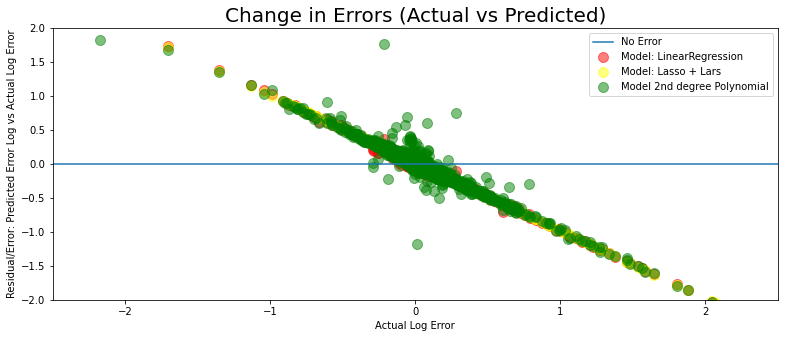

In [131]:
# y_validate.head()
plt.figure(figsize=(13,5))
plt.axhline(label="No Error")
plt.scatter(y_validate.log_error, y_validate.log_error_pred_lm-y_validate.log_error, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.log_error, y_validate.log_error_pred_lars-y_validate.log_error, 
            alpha=.5, color="yellow", s=100, label="Model: Lasso + Lars")
plt.scatter(y_validate.log_error, y_validate.log_error_pred_lm2-y_validate.log_error, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Log Error")
plt.ylabel("Residual/Error: Predicted Error Log vs Actual Log Error")
plt.title("Change in Errors (Actual vs Predicted)", size = 20)
plt.ylim(-2, 2)
plt.xlim(-2.5, 2.5)
plt.show()

### Best Model on Test Data (Unseen Data)

In [133]:
y_test = pd.DataFrame(y_test)
# predict on test
y_test['log_error_pred_lm'] = lm.predict(X_test)
# evaluate: rmse
rmse_test = mean_squared_error(y_test.log_error, y_test.log_error_pred_lm)**(1/2)
print("RMSE for OLS Model using LinearRegression\n\tOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
	Out-of-Sample Performance:  0.1591094033350667


> ### Modeling Summary 
- - Baseline Log Error Value: __0.19__
- Linear Regression Log Error Value (best model on test data): __0.1590__

> ## Recommendation 


# <u>Delivery</u>